## Analyzing prophages with Phaster

This notebook uses [Phaster](http://phaster.ca/) to detect potential prophages in bacterial and archaeal genomes. Prophages are bacteriophages (viruses that infect bacteria) that have inserted their DNA into a host bacterium's genome. Many bacteria contain prophages or remnants of ancient prophages, and we are interested in the relationship between the presence of prophages and having an active or inactive CRISPR system.

In [3]:
%matplotlib inline

In [69]:
#Import packages
import requests
import json
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import mlab
import seaborn as sns
import pandas as pd
from scipy.stats import poisson
from io import StringIO
import time
sns.set_palette("husl")

In [ ]:
# Create dictionary of prophages found in bacteria that have active CRISPR systems (confirmed by experiments)
prophages_dict = {}

# open the list of bacteria with active CRISPR systems
with open("../data/active_accessions.txt", "r") as f:
    for line in f:
        acc = line.rstrip()
        #print(acc)
        apiurl = "http://phaster.ca/phaster_api?acc={}".format(acc) 
        r=requests.get(apiurl)
        try:
            d=r.json()['summary']
        except ValueError:  # includes simplejson.decoder.JSONDecodeError
            # wait a delay and try again
            time.sleep(2)
            try:
                r=requests.get(apiurl)
                d=r.json()['summary']
            except ValueError:  # includes simplejson.decoder.JSONDecodeError
                print("Error acquiring results for accession %s" %acc)
        if d.find('Totally 0') != -1:
            prophages = False
            num_prophages = 0
        else:
            prophages = True
            # find number of prophages
            e='\n'.join(d.split('\n')[32:])
            data = pd.read_table(StringIO(e),skiprows=[1], delim_whitespace=True)
            num_prophages = sum(data['COMPLETENESS(score)'].str.contains('intact'))
        prophages_dict[acc] = num_prophages


In [ ]:
# Create dictionary of prophages found in bacteria that may not have active CRISPR systems

prophages_dict_all = {}

# make a list of the active bacteria
active_accessions = pd.read_table("../data/active_accessions.txt", dtype = "str", encoding = "utf-8", header = None)
active_accessions = active_accessions[0].tolist()

# open the total list of bacteria 
with open("../data/bac_accession_list.txt", "r") as f:
    for line in f:
        acc = line.rstrip()
        if acc in active_accessions:
            continue
        #print(acc)
        apiurl = "http://phaster.ca/phaster_api?acc={}".format(acc) 
        r=requests.get(apiurl)
        try:
            d=r.json()['summary']
        except ValueError:  # includes simplejson.decoder.JSONDecodeError
            print("Error acquiring results for accession %s" %acc)
        except KeyError:
            print(acc, r.json())     
        if d.find('Totally 0') != -1:
            prophages = False
            num_prophages = 0
        else:
            prophages = True
            # find number of prophages
            e='\n'.join(d.split('\n')[32:])
            data = pd.read_table(StringIO(e),skiprows=[1], delim_whitespace=True)
            num_prophages = sum(data['COMPLETENESS(score)'].str.contains('intact'))
        prophages_dict_all[acc] = num_prophages

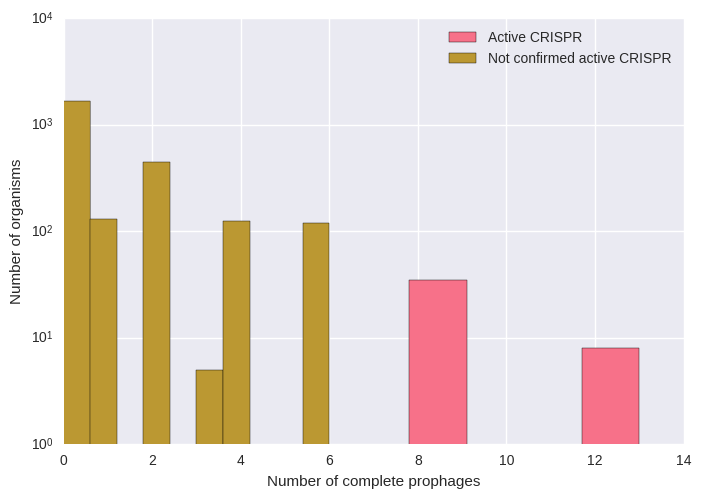

In [66]:
# Figure of number of prophages per active CRISPR compared with all organisms
plt.figure()
bins = plt.hist(list(prophages_dict.values()), label = 'Active CRISPR')
bins_all = plt.hist(list(prophages_dict_all.values()), label = 'Not confirmed active CRISPR')
plt.yscale('log')
plt.legend(loc='best')
plt.xlabel('Number of complete prophages')
plt.ylabel('Number of organisms')